## Importing required libraries

In [1]:
import sys, os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
import h5py
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import classification_report
import seaborn as sb
import tensorflow as tf

## Loading dataset and removing emotions

In [2]:
data = pd.read_csv("../input/fer2013/fer2013.csv")
data = data.drop('Usage', axis=1)
data = data[data['emotion'] != 1]

data.loc[data.emotion == 2, 'emotion'] = 1
data.loc[data.emotion == 3, 'emotion'] = 2
data.loc[data.emotion == 4, 'emotion'] = 3
data.loc[data.emotion == 5, 'emotion'] = 4
data.loc[data.emotion == 6, 'emotion'] = 5
data.loc[data.emotion == 7, 'emotion'] = 6

## Defining values reused throughout the code

In [3]:
num_labels = 6
batch_size = 64
epochs = 100
width, height = 48, 48

## Setting output path and name of model file

In [4]:
BASEPATH = '../output/kaggle/working'
MODELPATH = 'model_fer2013.h5'

## Preparing images for analysis (includes normalization)

In [5]:
faces = []
emotions = []

In [6]:
pixels = data['pixels'].tolist()
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(width, height)
    faces.append(face.astype('float32')/ 255.0)

faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)

emotions = pd.get_dummies(data['emotion']).values

## Defining labels which represent each emotion

In [7]:
labels = {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Sad', 4: 'Surprise', 5: 'Neutral'}

## Printing sample images from the dataset

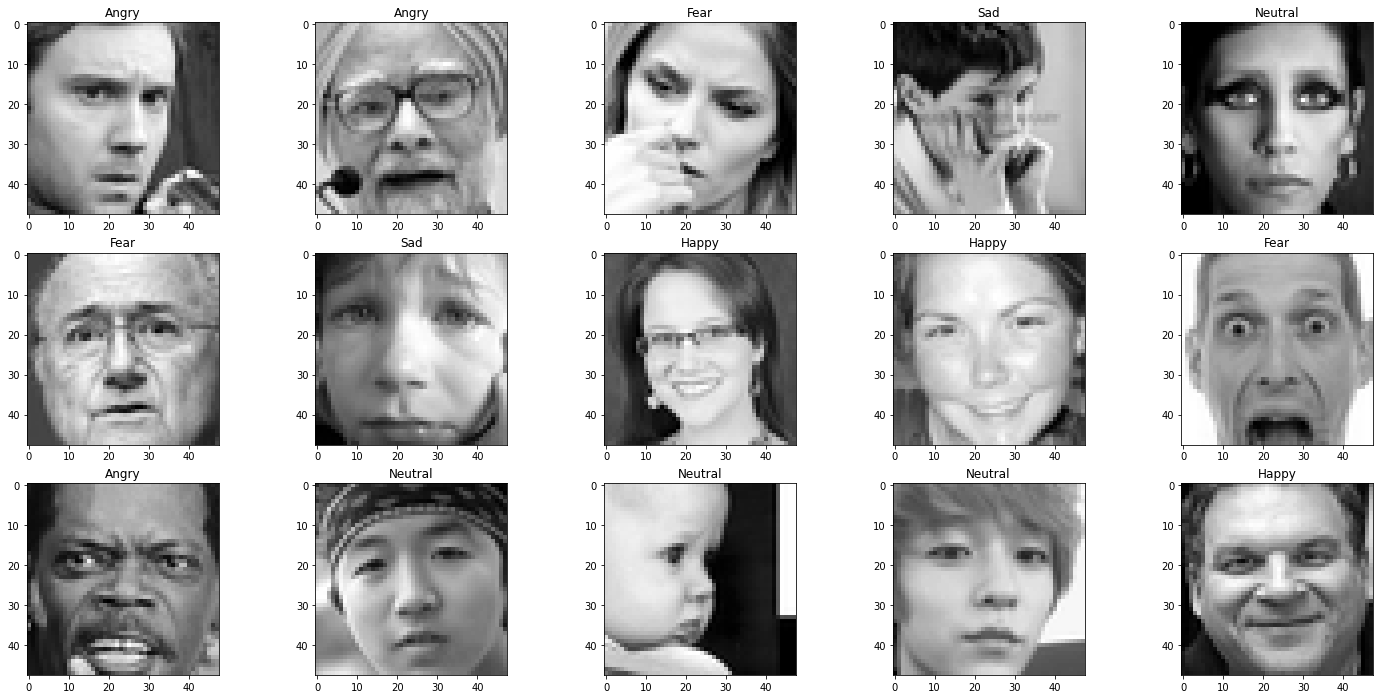

In [8]:
fig, axs = plt.subplots(3, 5, figsize=(25, 12))
axs = axs.ravel()
for i in range(15):
    axs[i].imshow(faces[i][:,:,0], cmap='gray')
    axs[i].set_title(str(labels[np.argmax(emotions[i])]))

## Splitting in to train, test, and validation datasets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

## Defining the model

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_labels, activation='softmax'))

## Printing model summary

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        1

## Compiling the model and defining options for the model

In [12]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [13]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)

In [14]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

In [15]:
checkpointer = ModelCheckpoint(MODELPATH, monitor='val_loss', verbose=1, save_best_only=True)

In [16]:
tensorboard = TensorBoard(log_dir='./logs')

## Training the model

In [17]:
history = model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_test), np.array(y_test)),
          shuffle=True, callbacks=[lr_reducer, tensorboard, early_stopper, checkpointer])

Epoch 1/100
448/448 [==============================] - 34s 61ms/step - loss: 2.3224 - accuracy: 0.2127 - val_loss: 2.0825 - val_accuracy: 0.2555

Epoch 00001: val_loss improved from inf to 2.08247, saving model to model_fer2013.h5
Epoch 2/100
448/448 [==============================] - 26s 58ms/step - loss: 1.6594 - accuracy: 0.3354 - val_loss: 1.6498 - val_accuracy: 0.3381

Epoch 00002: val_loss improved from 2.08247 to 1.64982, saving model to model_fer2013.h5
Epoch 3/100
448/448 [==============================] - 26s 57ms/step - loss: 1.4793 - accuracy: 0.4148 - val_loss: 1.4689 - val_accuracy: 0.4293

Epoch 00003: val_loss improved from 1.64982 to 1.46894, saving model to model_fer2013.h5
Epoch 4/100
448/448 [==============================] - 26s 57ms/step - loss: 1.4037 - accuracy: 0.4426 - val_loss: 1.3568 - val_accuracy: 0.4615

Epoch 00004: val_loss improved from 1.46894 to 1.35681, saving model to model_fer2013.h5
Epoch 5/100
448/448 [==============================] - 26s 58ms/

## Defining function for plotting the accuracy and loss of the model over the epochs

#### Taken from https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search

In [18]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    print(len(loss_list) , len(val_loss_list) , len(acc_list) , len(val_acc_list))
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Calling the above defined plot_history function

1 1 1 1


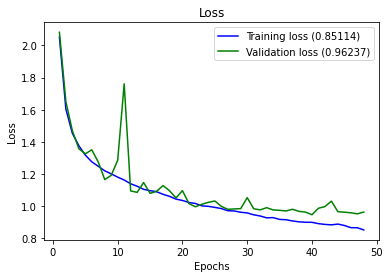

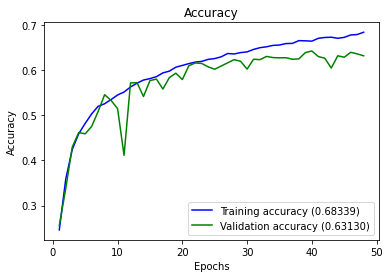

In [19]:
plot_history(history)

## Evaluating the performance of the model

In [20]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size=batch_size)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

56/56 [==============================] - 2s 44ms/step - loss: 0.9624 - accuracy: 0.6313
Loss: 0.9623691439628601
Accuracy: 0.6312959790229797


In [21]:
predictions=[np.argmax(im) for im in model.predict(np.array(X_test))]

In [22]:
emotion_labels = [np.argmax(i) for i in np.array(y_test)]

## Plotting the confusion matrix

<AxesSubplot:>

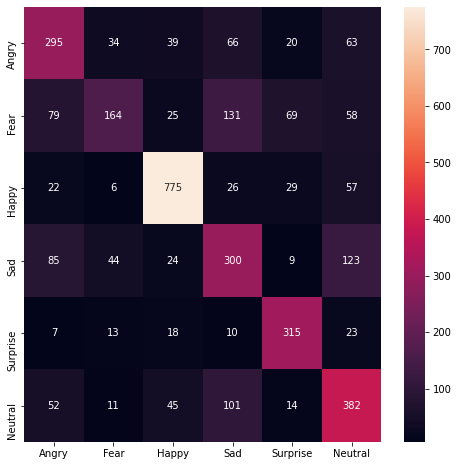

In [23]:
from sklearn.metrics import accuracy_score
em_names = ['Angry','Fear','Happy','Sad','Surprise','Neutral']
fig, ax = plt.subplots(figsize=(8, 8))
sb.heatmap(ax=ax, 
           data=pd.DataFrame(tf.math.confusion_matrix(emotion_labels, predictions, num_classes=6).numpy().astype(int), 
                     index=em_names, 
                     columns=em_names
           ), 
           annot=True, 
           annot_kws={"size": 10},
           fmt='g'
          )

## Printing the classification report

In [24]:
Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(Y_test, y_pred, target_names= em_names))

              precision    recall  f1-score   support

       Angry       0.55      0.57      0.56       517
        Fear       0.60      0.31      0.41       526
       Happy       0.84      0.85      0.84       915
         Sad       0.47      0.51      0.49       585
    Surprise       0.69      0.82      0.75       386
     Neutral       0.54      0.63      0.58       605

    accuracy                           0.63      3534
   macro avg       0.62      0.61      0.61      3534
weighted avg       0.63      0.63      0.62      3534



## Plotting sample images misclassified by the model

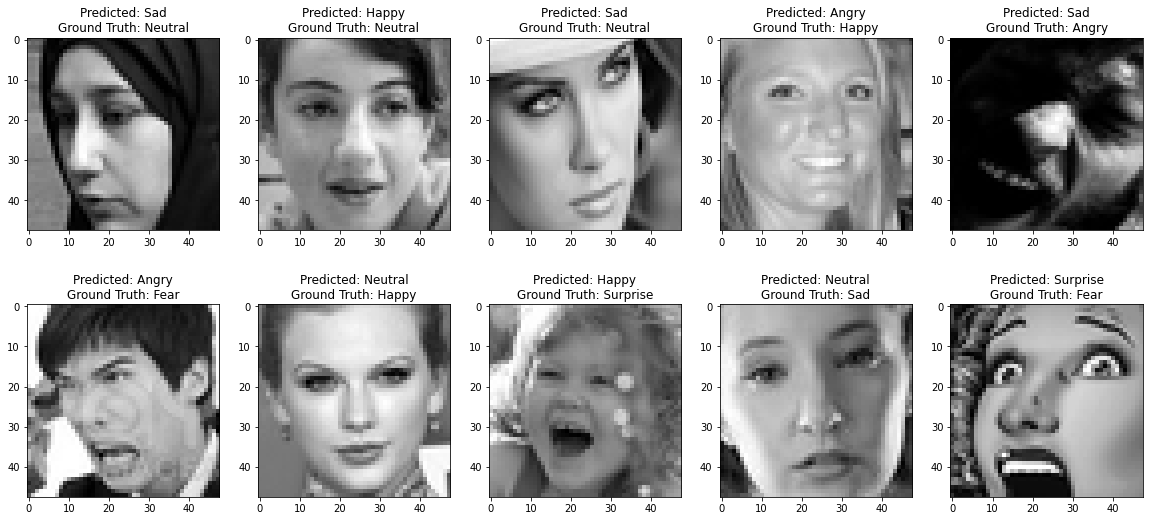

In [25]:
rows = 0
cols = 0
disagree = []
for i in range(len(emotion_labels)):
    if emotion_labels[i] != predictions[i]:
        disagree.append(i)
        if len(disagree) == 10:
            break

fig, axs = plt.subplots(2, 5, figsize=(20,9))

for i in range(10):
    image=(np.array(list(X_test)[disagree[i]])/256)[:,:,0]
    axs[cols, rows].imshow(image, cmap='gray')
    axs[cols, rows].set_title('Predicted: ' + str(labels[predictions[disagree[i]]]) + '\nGround Truth: ' + str(labels[emotion_labels[disagree[i]]]))
    rows = rows+1
    if rows == 5:
        cols = cols + 1
        rows = 0

# Evaluating the performance of VGG16 on the same dataset

## Normalizing and stacking the grayscale images into 3 bands as VGG requires 3 band images

In [26]:
from keras.applications.vgg16 import VGG16

In [27]:
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(width, height)
    face = cv2.merge((face,face,face))
    faces.append(face.astype('float32')/255.0)

faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)

## Splitting in to train, test, and validation datasets

In [28]:
X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

## Importing the VGG16 model

In [29]:
model_base = VGG16(include_top=False,
                      weights='imagenet',
                      input_shape=(width, height, 3))
for layer in model_base.layers[:-2]:
    layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


## Defining the model using the VGG16 as the base and adding the Softmax layer

In [30]:
model = Sequential()
model.add(model_base)
model.add(Flatten())
model.add(Dense(num_labels, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 3078      
Total params: 14,717,766
Trainable params: 2,362,886
Non-trainable params: 12,354,880
_________________________________________________________________


## Compiling, training, and evaluating the VGG16 model

In [31]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [ ]:
model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_test), np.array(y_test)),
          shuffle=True, callbacks=[lr_reducer, tensorboard, early_stopper, checkpointer])

In [ ]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size=batch_size)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

## 